<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 2 &ndash; The Vanishing Gradient Problem (Assignment)</h2>

In [1]:
# Import pre-defined utilities specific to this notebook.
import u2_utils as u2

# Import additional utilities needed in this notebook.
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from typing import Dict, Sequence

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u2.setup_jupyter()

# Check minimum versions.
u2.check_module_versions()

Installed Python version: 3.10 (✓)
Installed numpy version: 1.22.4 (✓)
Installed pandas version: 1.5.3 (✓)
Installed PyTorch version: 2.0.1+cu118 (✓)
Installed scikit-learn version: 1.2.2 (✓)
Installed matplotlib version: 3.7.1 (✓)
Installed seaborn version: 0.12.2 (✓)


<h2>Definition of Auxiliaries</h2>

In this exercise, you will be working with a data set composed of images of various handwritten digits. It is probably <i>the</i> most prominent data set in the domain of machine learning: the <i>MNIST</i> data set. The data set distinguishes <i>ten</i> different classes, one for each digit (<i>zero</i> to <i>nine</i>). For curious minds, more information regarding this data set can be found at:

<center>
    <cite>LeCun, Y., 1998. The MNIST database of handwritten digits. <a href="http://yann.lecun.com/exdb/mnist/">http://yann.lecun.com/exdb/mnist/</a>.</cite>
</center><br>
    
Before analyzing and tackling the vanishing gradient problem, the data sets needs to be inspected.

<div class="alert alert-warning">
    <b>Exercise 1.1. [3 Points]</b>
    <ul>
        <li>Load the <i>MNIST</i> data set using the appropriate function as supplied by us.</li>
        <li>Split the data set into a training set and a test set in a ratio of $4:1$.</li>
        <li>Visualize the MNIST training set in tabular form.</li>
    </ul>
</div>

In [2]:
data_mnist = u2.load_mnist()
data_mnist_train, data_mnist_test = u2.split_data(data_mnist, test_size=1.0/4.0)
data_mnist

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,digit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


<div class="alert alert-warning">
    <b>Exercise 1.2. [3 Points]</b><br>
    Answer the following questions:
    <ul>
        <li>How many samples does the data set contain?</li>
        70000
        <li>How many samples does the training and the test set contain?
        </li>Respectively 56000 and 14000
        <li>How many features does the data set consist of (not counting the class label column <i>digit</i>)?</li>784
    </ul>
</div>

<div class="alert alert-warning">
    <b>Exercise 1.3. [6 Points]</b>
    <ul>
        <li>Reduce the dimensionality of the MNIST training set using <i>t-SNE</i>. To avoid long computation times, select a subset of the training data with $n=2000$ samples, and then perform <i>PCA</i> with $40$ components first. Afterwards, apply t-SNE with $2$ components on this PCA data (choose the perplexity yourself).</li>
        <li>Visualize the t-SNE downprojection.</li>
    </ul>
</div>

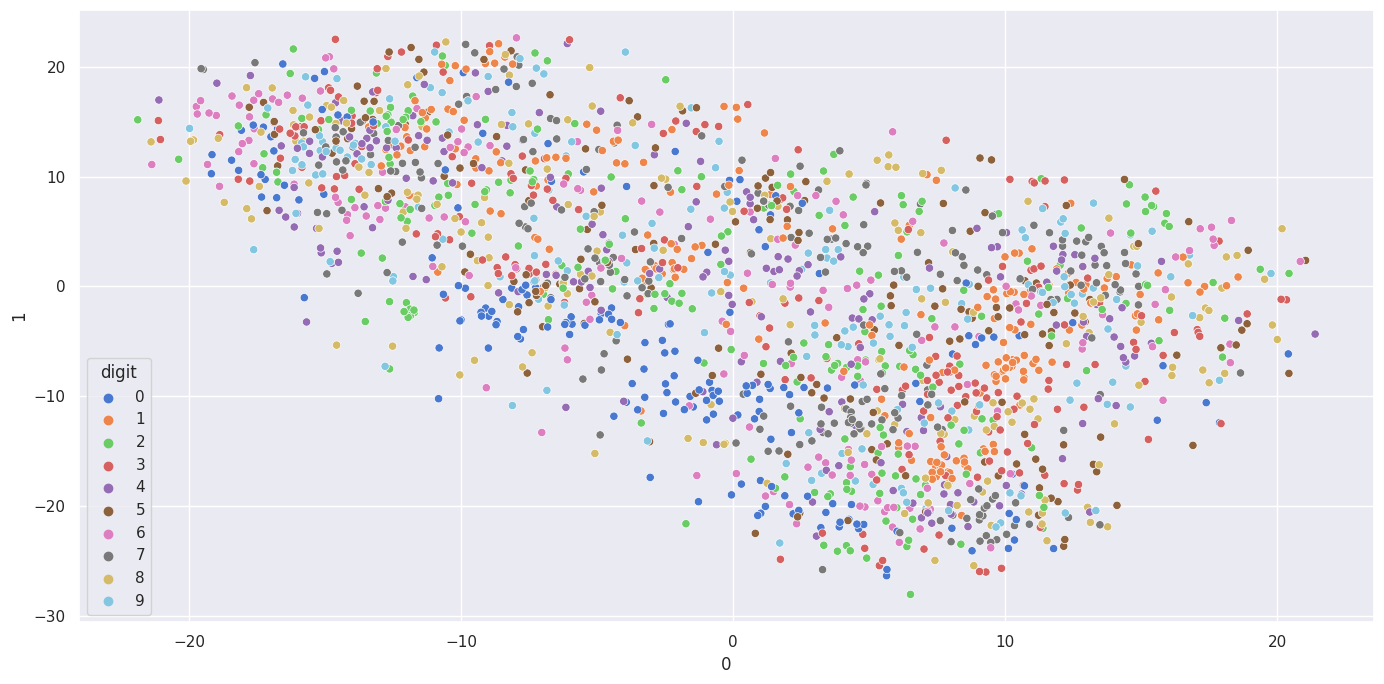

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
u2.set_seed(17)
reduced_data = data_mnist_train[:2000]
data_mnist_X, data_mnist_Y = reduced_data.drop(columns='digit'), reduced_data['digit']
data_mnist_pca = u2.apply_pca(n_components=40, data=data_mnist_X)
u2.set_seed(17)
data_mnist_tsne = u2.apply_tsne(n_components=2, data=data_mnist_X, perplexity=2)
u2.plot_points_2d(data=data_mnist_tsne, targets=data_mnist_Y, figsize=(14, 7))

<div class="alert alert-warning">
    <b>Exercise 1.4. [2 Points]</b>
    <ul>
        <li>Comment on the separability of the MNIST training (sub)set with respect to the downprojection.</li>
    </ul>
</div>

It seems it is extremely hard to separate the data. They are close to each other and there is no certain pattern.

<div class="alert alert-warning">
    <b>Exercise 1.5. [2 Points]</b>
    <ul>
        <li>Given the results above, do you think that there is some model that can classify the data set (decently) well? State your reasoning.</li>
    </ul>
</div>

According to the results above there cannot be a model to classify the data well without doing overfitting.

<h2>Training of a Neural Network</h2>

Loading and inspecting a new data set is always an exciting moment, but even more exciting is the implementation of a corresponding neural network and applying it to said data set. In this section, you will thus have to implement and train an appropriate neural network model and revisit your knowledge about the <i>forward</i> as well as the <i>backward</i> pass.

<div class="alert alert-warning">
    <b>Important:</b> The following code snippet is taken from the accompanying exercise notebook. Do not modify this code here.
</div>

In [4]:
def train_and_evaluate(model: torch.nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int,
                       loader_train: torch.utils.data.DataLoader, loader_test: torch.utils.data.DataLoader,
                       device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) -> None:
    """
    Auxiliary function for training and evaluating a corresponding model.

    :param model: model instance to train and evaluate
    :param optimizer: optimizer to use for model training
    :param num_epochs: amount of epochs for model training
    :param loader_train: data loader supplying the training samples
    :param loader_test: data loader supplying the test samples
    :param device: device to use for model training and evaluation
    """
    model.to(device)

    for epoch in range(num_epochs):
        # Train model instance for one epoch.
        u2.train_network(
            model=model,
            data_loader=loader_train,
            device=device,
            optimizer=optimizer
        )

        # Evaluate current model instance.
        performance = u2.test_network(
            model=model,
            data_loader=loader_train,
            device=device
        )

        # Print result of current epoch to standard out.
        print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
              f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

    # Evaluate final model on test data set.
    performance = u2.test_network(model=model, data_loader=loader_test, device=device)
    print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

    

<div class="alert alert-warning">
    <b>Exercise 2.1. [7 Points]</b>
    <ul>
        <li>Create a corresponding <code>TensorDataset</code> for the training as well as the test set.</li>
        <li>Wrap the previously defined <code>TensorDataset</code> instances in separate <code>DataLoader</code> instances with a batch size of $80$ (shuffle the training data set).</li>
        <li>Scale the features of the training as well as test set by a factor of $\frac{1}{255}$, i.e., normalize the data to range $[0; 1]$</li>
    </ul>
</div>

In [6]:
loader_fashion_mnist_train = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(data_mnist_train.drop(columns=['digit']).values / 255),  # normalize to range [0; 1]
        torch.from_numpy(data_mnist_train['digit'].values)
    ),
    batch_size=128,
    shuffle=True
)

loader_fashion_mnist_test = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(data_mnist_test.drop(columns=['digit']).values / 255),  # normalize to range [0; 1]
        torch.from_numpy(data_mnist_test['digit'].values)
    ),
    batch_size=80,
    shuffle=False
)

<div class="alert alert-warning">
    <b>Exercise 2.2. [9 Points]</b>
    <ul>
        <li>Implement a class <code>FNN_0</code> with the following architecture (square weight matrix means that the input size is equal to the output size):</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>input size = $28\times{}28 = 784$</td>
        </tr>
        <tr>
            <td>1</td>
            <td>fully connected</td>
            <td>$512$ output features</td>
        </tr>
        <tr>
            <td>2</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>4</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>5</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>6</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>7</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>8</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>9</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>10</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>11</td>
            <td>fully connected</td>
            <td>$10$ output features</td>
        </tr>
    </table>
</div>

In [7]:
import torch
import torch.nn as nn

class FNN_0(nn.Module):
    def __init__(self):
        super(FNN_0, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(512, 512)
        self.sigmoid2 = nn.Sigmoid()
        self.fc3 = nn.Linear(512, 512)
        self.sigmoid3 = nn.Sigmoid()
        self.fc4 = nn.Linear(512, 512)
        self.sigmoid4 = nn.Sigmoid()
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.fc2(x)
        x = self.sigmoid2(x)
        x = self.fc3(x)
        x = self.sigmoid3(x)
        x = self.fc4(x)
        x = self.sigmoid4(x)
        x = self.fc5(x)
        return x

<div class="alert alert-warning">
    <b>Exercise 2.3. [3 Points]</b>
    <ul>
        <li>Create an instance of <code>FNN_0</code> as well as of a corresponding <code>SGD</code> optimizer with a learning rate of $0.05$.</li>
        <li>Print the resulting model and verify the architecture by inspecting the output.</li>
    </ul>
</div>

In [12]:
fnn_model = FNN_0()
optimizer = torch.optim.SGD(fnn_model.parameters(), lr=0.05)
print(fnn_model)

FNN_0(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (sigmoid1): Sigmoid()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (sigmoid2): Sigmoid()
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (sigmoid3): Sigmoid()
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (sigmoid4): Sigmoid()
  (fc5): Linear(in_features=512, out_features=10, bias=True)
)


<div class="alert alert-warning">
    <b>Exercise 2.4. [5 Points]</b>
    <ul>
        <li>Train an <code>FNN_0</code> network for $6$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy.</li>
    </ul>
</div>

In [17]:
num_epochs = 6

train_and_evaluate(
    model=fnn_model,
    optimizer=optimizer,
    num_epochs=num_epochs,
    loader_train=loader_fashion_mnist_train,
    loader_test=loader_fashion_mnist_test,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

Epoch: 1 / Train loss: 0.0182 / Train accuracy: 0.1125
Epoch: 2 / Train loss: 0.0184 / Train accuracy: 0.1125
Epoch: 3 / Train loss: 0.0184 / Train accuracy: 0.0980
Epoch: 4 / Train loss: 0.0182 / Train accuracy: 0.0899
Epoch: 5 / Train loss: 0.0184 / Train accuracy: 0.0980
Epoch: 6 / Train loss: 0.0183 / Train accuracy: 0.0980

Test loss: 0.0292 / Test accuracy: 0.0988


<h2>Analyzing Gradients</h2>

Is the performance problem of <code>FNN_0</code> related to the vanishing gradient problem? This is exactly the point you're going to figure out in this exercise. As a first step, the gradients of a freshly initialized model need to be collected and analyzed. Afterwards, in case of a vanishing gradient problem, countermeasures must be taken.</p>

<div class="alert alert-warning">
    <b>Important:</b> The following code snippet is taken from the accompanying exercise notebook. Do not modify this code here.
</div>

In [18]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader,
                      device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) -> Sequence[Dict[str, np.array]]:
    """
    Auxiliary function for collecting gradients of a corresponding model.

    :param model: model instance to be used for collecting gradients
    :param loader: data loader supplying the samples used for collecting gradients
    :param device: device to use for gradient collection
    :return: sequence of parameter names and gradients, averaged over all parameter elements
    """
    model.to(device)
    model_state = model.training
    model.train()
    model.zero_grad()

    # Iterating over the data set and computing the corresponding gradients.
    # Since we are only interested in the gradients, we can skip the optimization step.
    gradients = {}
    criterion = torch.nn.CrossEntropyLoss()

    for data, target in loader:
        data, target = data.float().to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Collecting the (averaged absolute) gradients from the current model.
        for name, parameter in model.named_parameters():
            if "weight" in name and parameter.grad is not None:
                gradients.setdefault(name, []).append(parameter.grad.view(-1).abs().mean().item())
        model.zero_grad()

    # Reset model state and return collected gradients.
    model.train(mode=model_state)
    return gradients

<div class="alert alert-warning">
    <b>Exercise 3.1. [3 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>FNN_0</code> and collect its gradients using the MNIST training set.</li>
    </ul>
</div>

In [20]:
fresh_model = FNN_0()
fresh_gradients = collect_gradients(fresh_model, loader_fashion_mnist_train, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

<div class="alert alert-warning">
    <b>Exercise 3.2. [3 Points]</b>
    <ul>
        <li>Visualize the gradients of each weight parameter accordingly.</li>
    </ul>
</div>

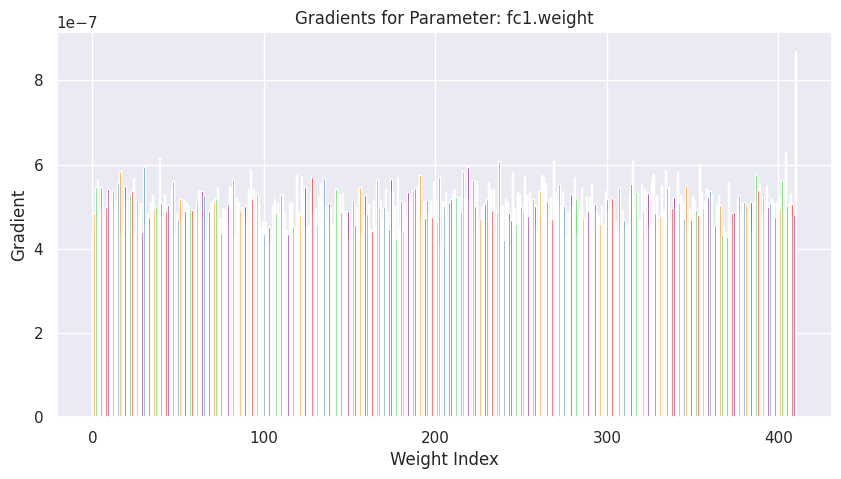

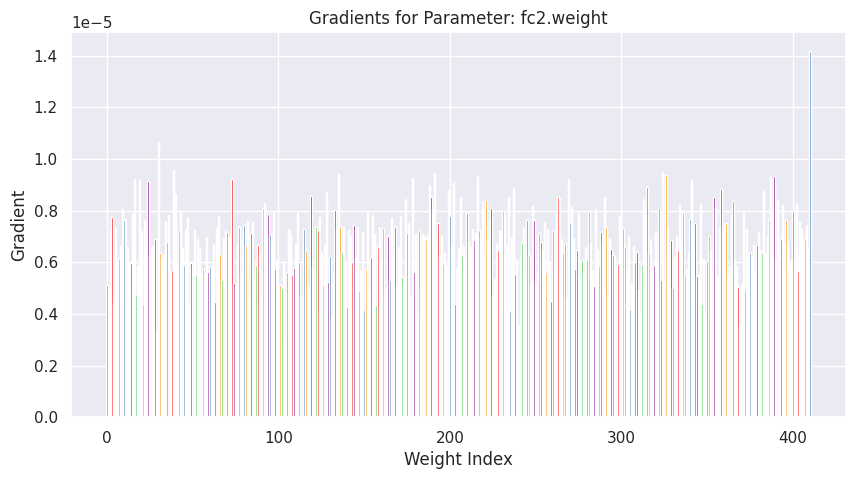

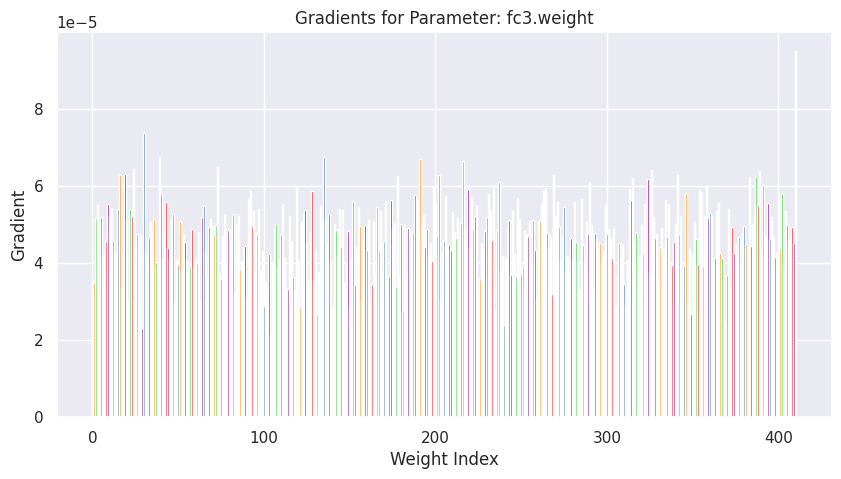

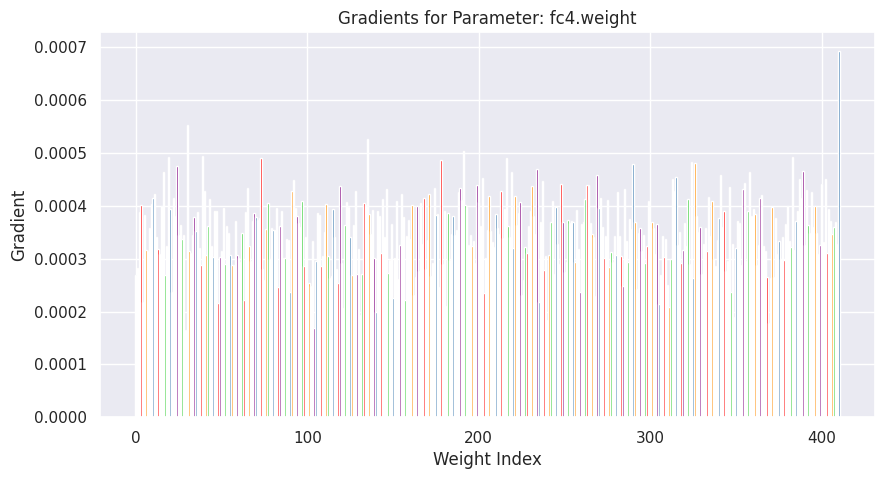

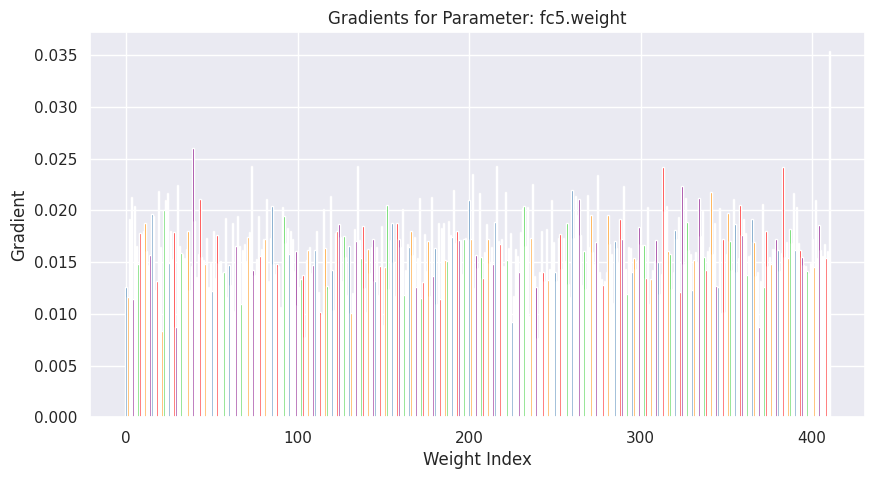

In [22]:
import matplotlib.pyplot as plt

# Define custom colors for the bar plot
bar_colors = ['steelblue', 'darkorange', 'limegreen', 'red', 'purple']

# Iterate over the weight parameters and their gradients
for param_name, gradients in fresh_gradients.items():
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(gradients)), gradients, color=bar_colors)
    plt.xlabel('Weight Index')
    plt.ylabel('Gradient')
    plt.title(f'Gradients for Parameter: {param_name}')
    plt.show()

<div class="alert alert-warning">
    <b>Exercise 3.4. [8 Points]</b>
    <ul>
        <li>Assume a vanishing gradient. Apply the countermeasure presented during the accompanying exercise by implementing a corresponding <code>FNN_1</code> network.</li>
    </ul>
</div>

In [25]:
class FNN_1(nn.Module):
    def __init__(self):
        super(FNN_1, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 512)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(512, 512)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

<div class="alert alert-warning">
    <b>Exercise 3.5. [3 Points]</b>
    <ul>
        <li>Create an instance of <code>FNN_1</code> as well as of a corresponding <code>SGD</code> optimizer with a learning rate of $0.05$.</li>
        <li>Print the resulting model and verify the architecture by inspecting the output.</li>
    </ul>
</div>

In [27]:
fnn_1 = FNN_1()
optimizer = torch.optim.SGD(fnn_1.parameters(), lr=0.05)

<div class="alert alert-warning">
    <b>Exercise 3.6. [5 Points]</b>
    <ul>
        <li>Train an <code>FNN_1</code> network for $6$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy.</li>
    </ul>
</div>

In [28]:
num_epochs = 10

model = FNN_1()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
num_epochs = 6

train_and_evaluate(
    model=model,
    optimizer=optimizer,
    num_epochs=num_epochs,
    loader_train=loader_fashion_mnist_train,
    loader_test=loader_fashion_mnist_test,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

Epoch: 1 / Train loss: 0.0067 / Train accuracy: 0.7314
Epoch: 2 / Train loss: 0.0019 / Train accuracy: 0.9243
Epoch: 3 / Train loss: 0.0022 / Train accuracy: 0.9110
Epoch: 4 / Train loss: 0.0007 / Train accuracy: 0.9756
Epoch: 5 / Train loss: 0.0014 / Train accuracy: 0.9441
Epoch: 6 / Train loss: 0.0005 / Train accuracy: 0.9829

Test loss: 0.0012 / Test accuracy: 0.9710


<div class="alert alert-warning">
    <b>Exercise 3.8. [3 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>FNN_1</code> and collect its gradients using the MNIST training set.</li>
    </ul>
</div>

In [29]:
f_model = FNN_1()
f_gradients = collect_gradients(f_model, loader_fashion_mnist_train, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

<div class="alert alert-warning">
    <b>Exercise 3.9. [3 Points]</b>
    <ul>
        <li>Visualize the gradients of each weight parameter accordingly. Include the gradient visualization of <code>FNN_0</code> to enable a direct comparison.</li>
    </ul>
</div>

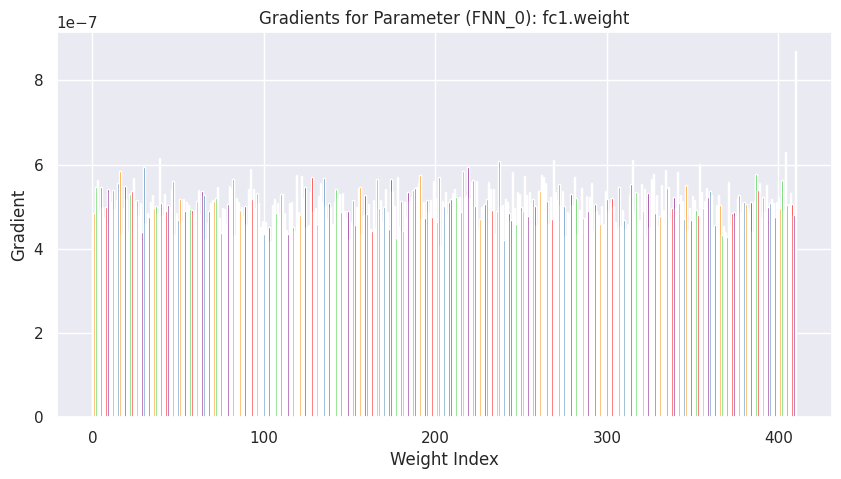

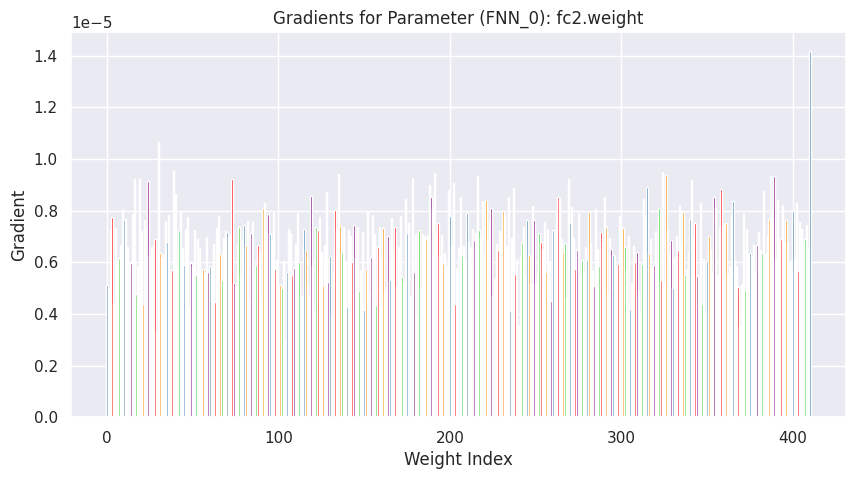

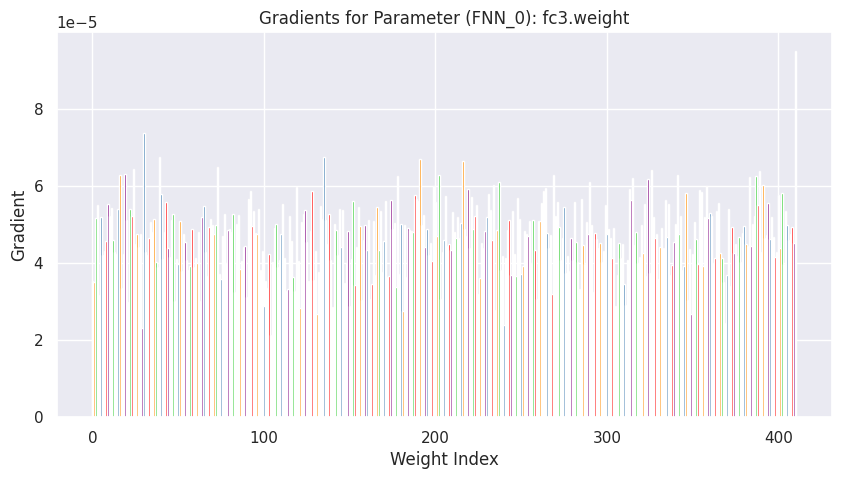

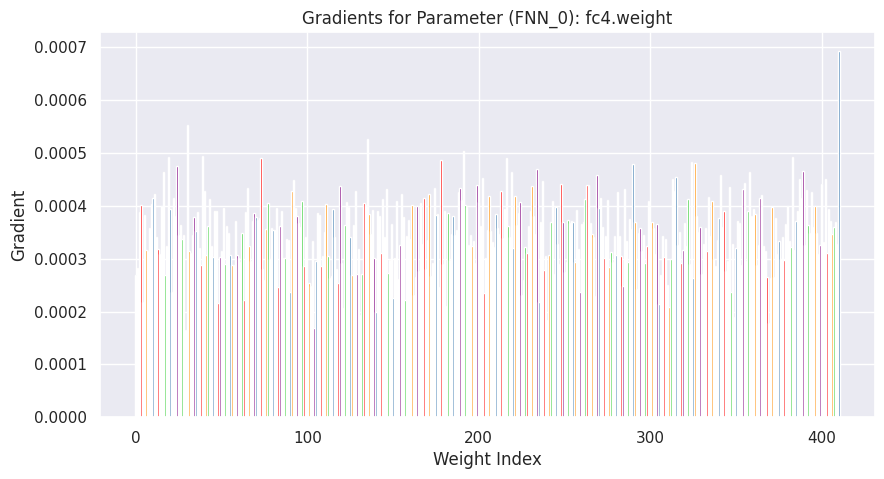

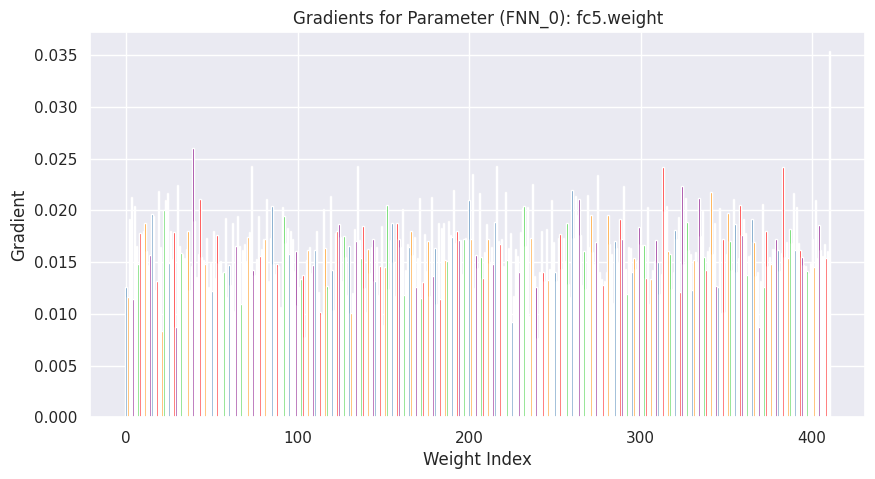

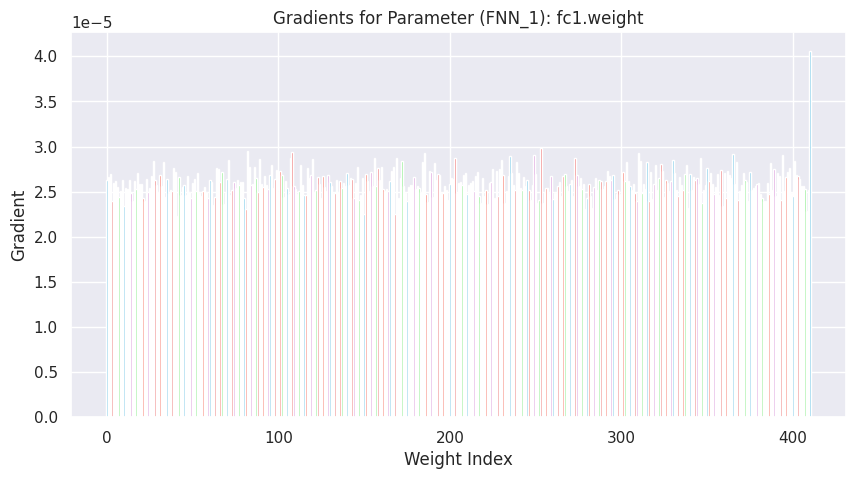

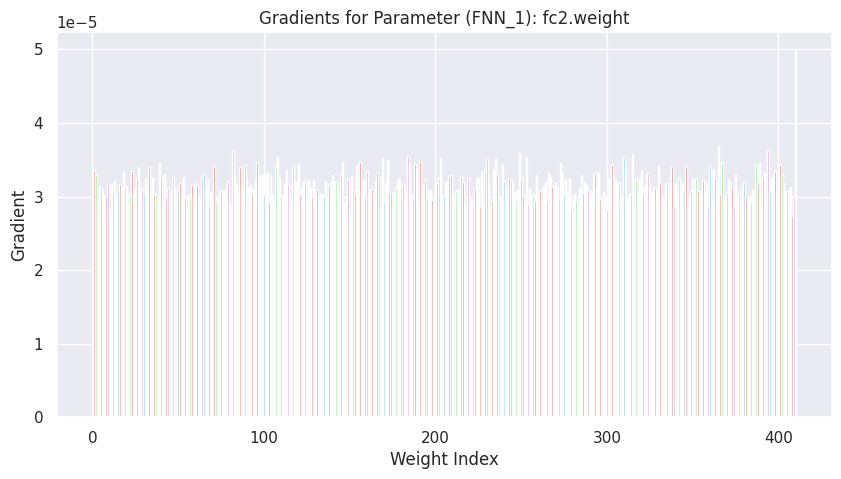

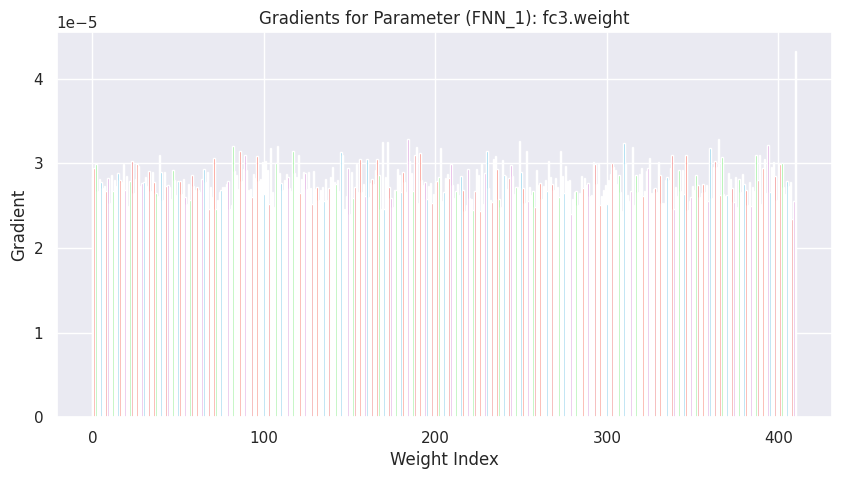

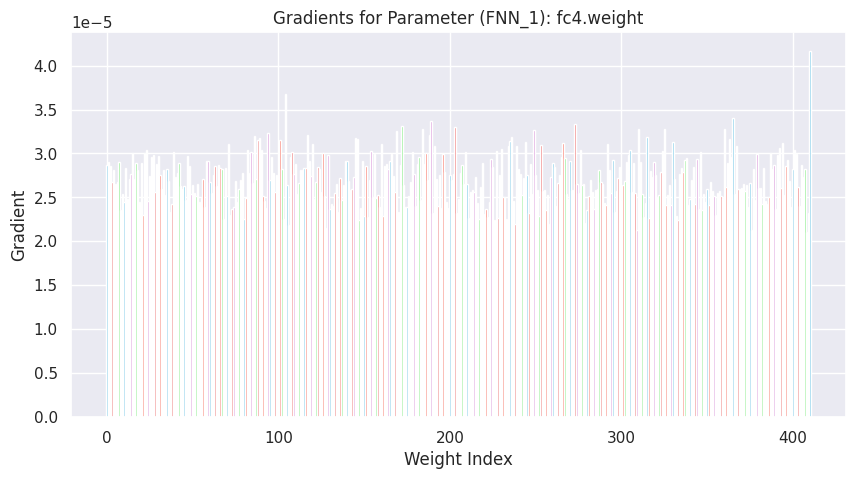

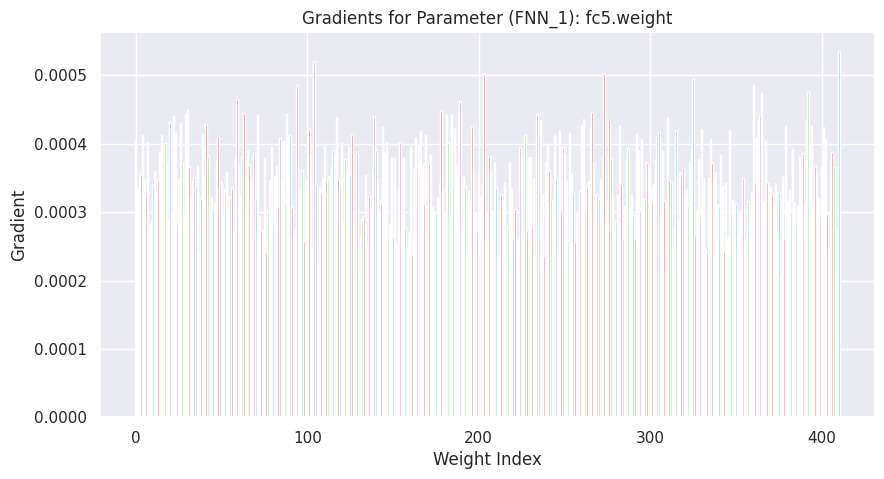

In [46]:
# Define custom colors for the bar plot
bar_colors_fnn0 = ['steelblue', 'darkorange', 'limegreen', 'red', 'purple']
bar_colors_fnn1 = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'plum']

# Iterate over the weight parameters and their gradients for FNN_0
for param_name, gradients in fresh_gradients.items():
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(gradients)), gradients, color=bar_colors_fnn0)
    plt.xlabel('Weight Index')
    plt.ylabel('Gradient')
    plt.title(f'Gradients for Parameter (FNN_0): {param_name}')
    plt.show()

# Iterate over the weight parameters and their gradients for FNN_1
for param_name, gradients in f_gradients.items():
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(gradients)), gradients, color=bar_colors_fnn1)
    plt.xlabel('Weight Index')
    plt.ylabel('Gradient')
    plt.title(f'Gradients for Parameter (FNN_1): {param_name}')
    plt.show()

<h2>Deriving Derivatives</h2>

It is already known from the lecture as well as the exercise that <i>activation</i> functions are the primary culprit of the <i>Vanishing Gradient Problem</i>. Hence, it is important to know <i>how</i> the chosen activation functions activate the input and consequently what the <i>derivative</i> is.

<div class="alert alert-warning">
    <b>Exercise 4.1. [5 Points]</b><br>
    Take a look at the official <a href="https://pytorch.org/docs/stable/generated/torch.nn.Hardsigmoid.html#torch.nn.Hardsigmoid">PyTorch documentation</a> to solve the following tasks:
    <ul>
        <li>Implement the <code>hardsigmoid</code> activation function as it was done for <code>relu</code> in the exercise.</li>
        <li>Implement the <i>derivative</i> of the <code>hardsigmoid</code> activation function accordingly.</li>
    </ul>
</div>

In [35]:
def hardsigmoid(x):
    return np.clip(np.array(x) * 0.2 + 0.5, 0, 1)

def hardsigmoid_derivative(x):
    return np.where((np.array(x) >= -2.5) & (np.array(x) <= 2.5), 0.2, 0.0)

<div class="alert alert-warning">
    <b>Exercise 4.2. [5 Points]</b>
    <ul>
        <li>Find $5$ different inputs showing the <i>value range</i> of the <code>hardsigmoid</code> activation function as well as its derivative.</li>
        <li>Plot the <code>hardsigmoid</code> activation function including its derivative for the input range $[-8; 8]$.</li>
    </ul>
</div>

In [38]:
inputs = [-8, -4, 0, 5, 9]
hardsigmoid_values = hardsigmoid(inputs)
hardsigmoid_derivative_values = hardsigmoid_derivative(inputs)

print("Hardsigmoid values:")
for i, val in enumerate(hardsigmoid_values):
    print(f"Input: {inputs[i]}, Hardsigmoid: {val}")

print("\nHardsigmoid derivative values:")
for i, val in enumerate(hardsigmoid_derivative_values):
    print(f"Input: {inputs[i]}, Derivative: {val}")

Hardsigmoid values:
Input: -8, Hardsigmoid: 0.0
Input: -4, Hardsigmoid: 0.0
Input: 0, Hardsigmoid: 0.5
Input: 5, Hardsigmoid: 1.0
Input: 9, Hardsigmoid: 1.0

Hardsigmoid derivative values:
Input: -8, Derivative: 0.0
Input: -4, Derivative: 0.0
Input: 0, Derivative: 0.2
Input: 5, Derivative: 0.0
Input: 9, Derivative: 0.0


<div class="alert alert-warning">
    <b>Exercise 4.3. [4 Points]</b><br>
    Take a look at the official <a href="https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU">PyTorch documentation</a> to solve the following tasks:
    <ul>
        <li>Implement the <code>leaky_relu</code> activation function as it was done for <code>relu</code> in the exercise. Use a <i>negative slope</i> of $0.25$.</li>
        <li>Implement the <i>derivative</i> of the <code>leaky_relu</code> activation function accordingly.</li>
    </ul>
</div>

In [41]:
def leaky_relu(x, negative_slope=0.25):
    return np.maximum(0, np.array(x)) + negative_slope * np.minimum(0, np.array(x))

def leaky_relu_derivative(x, negative_slope=0.25):
    return np.where(np.array(x) >= 0, 1, negative_slope)

<div class="alert alert-warning">
    <b>Exercise 4.4. [3 Points]</b>
    <ul>
        <li>Find $5$ different inputs showing the <i>value range</i> of the <code>leaky_relu</code> activation function as well as its derivative.</li>
        <li>Plot the <code>leaky_relu</code> activation function including its derivative for the input range $[-8; 8]$.</li>
    </ul>
</div>

In [42]:
inputs = [-9, -5, 0, 4, 8]
leaky_relu_values = leaky_relu(inputs)
leaky_relu_derivative_values = leaky_relu_derivative(inputs)

print("Leaky ReLU values:")
for i, val in enumerate(leaky_relu_values):
    print(f"Input: {inputs[i]}, Leaky ReLU: {val}")

print("\nLeaky ReLU derivative values:")
for i, val in enumerate(leaky_relu_derivative_values):
    print(f"Input: {inputs[i]}, Derivative: {val}")

Leaky ReLU values:
Input: -9, Leaky ReLU: -2.25
Input: -5, Leaky ReLU: -1.25
Input: 0, Leaky ReLU: 0.0
Input: 4, Leaky ReLU: 4.0
Input: 8, Leaky ReLU: 8.0

Leaky ReLU derivative values:
Input: -9, Derivative: 0.25
Input: -5, Derivative: 0.25
Input: 0, Derivative: 1.0
Input: 4, Derivative: 1.0
Input: 8, Derivative: 1.0


<div class="alert alert-warning">
    <b>Exercise 4.5. [3 Points]</b>
    <ul>
        <li>Which of these two activation functions from above do you think is susceptible to the vanishing gradient problem? Explain your decision.</li>
    </ul>
</div>

Leaky ReLu looks better in terms of vanishing gradient problem since its values are bigger.

<div class="alert alert-warning">
    <b>Exercise 4.6. [6 Points]</b>
    <ul>
        <li>Create the same network architecture as <code>FNN_0</code> but replace its activation function with the one you selected above in <b>Exercise 4.5.</b> (the one that is susceptible to the vanishing gradient problem). Name the new network <code>FNN_2</code>.</li>
    </ul>
</div>

In [43]:
class FNN_2(nn.Module):
    def __init__(self):
        super(FNN_2, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.leaky_relu1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(512, 512)
        self.leaky_relu2 = nn.LeakyReLU(0.25)
        self.fc3 = nn.Linear(512, 512)
        self.leaky_relu3 = nn.LeakyReLU(0.25)
        self.fc4 = nn.Linear(512, 512)
        self.leaky_relu4 = nn.LeakyReLU(0.25)
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.fc4(x)
        x = self.leaky_relu4(x)
        x = self.fc5(x)
        return x

<div class="alert alert-warning">
    <b>Exercise 4.7. [3 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>FNN_2</code> and collect its gradients using the MNIST training set.</li>
    </ul>
</div>

In [44]:
_model = FNN_2()
_gradients = collect_gradients(_model, loader_fashion_mnist_train, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

<div class="alert alert-warning">
    <b>Exercise 4.8. [3 Points]</b>
    <ul>
        <li>Visualize the gradients of each weight parameter accordingly. Include the gradient visualization of <code>FNN_0</code> to enable a direct comparison.</li>
    </ul>
</div>

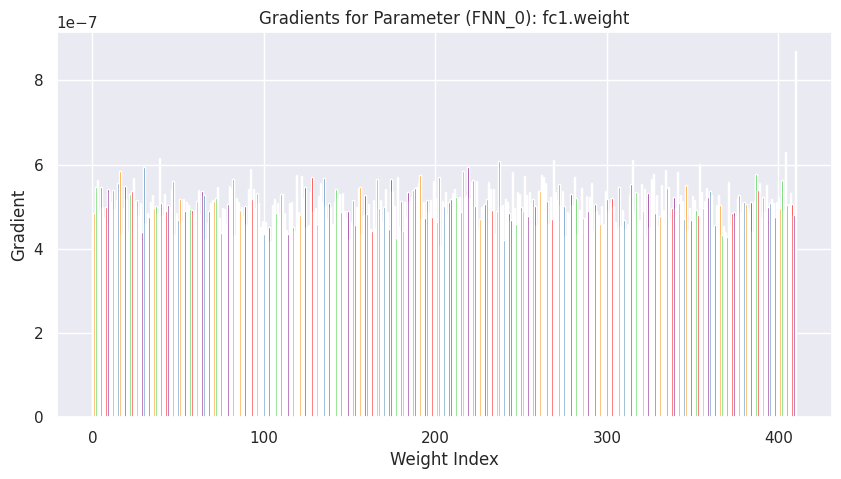

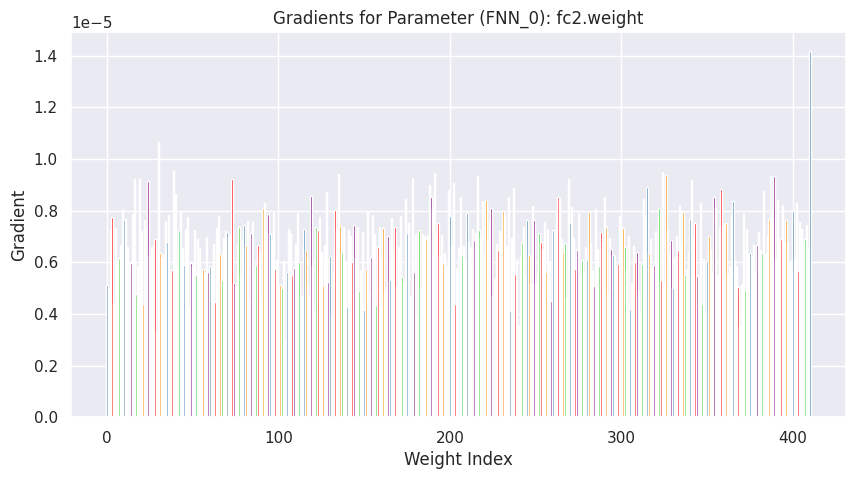

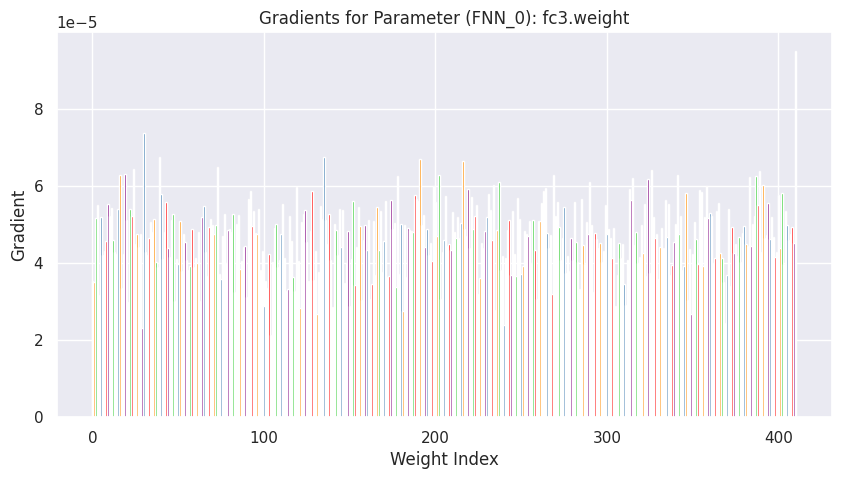

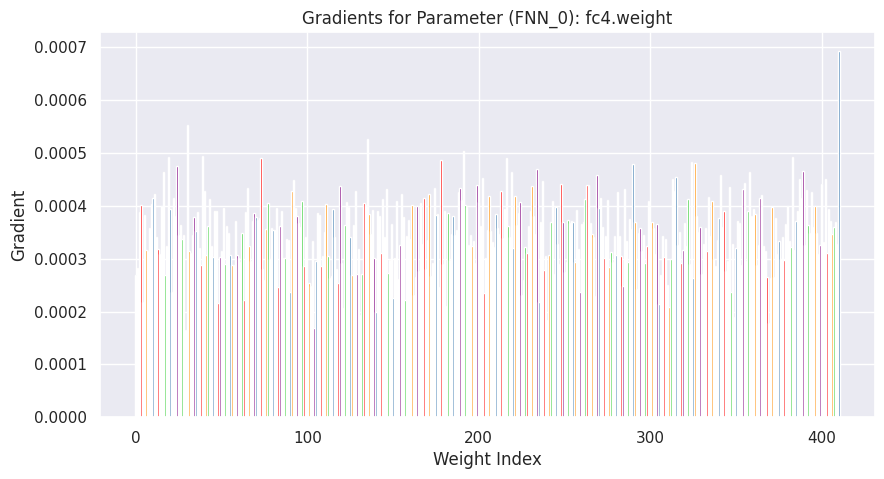

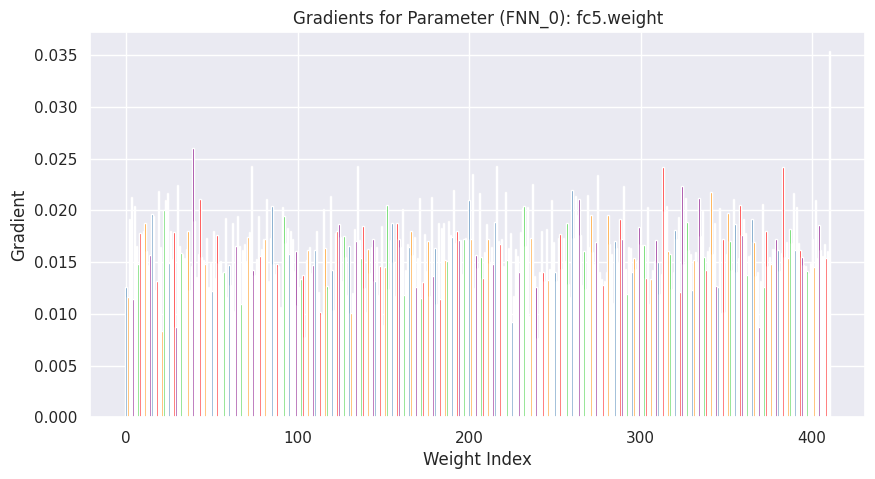

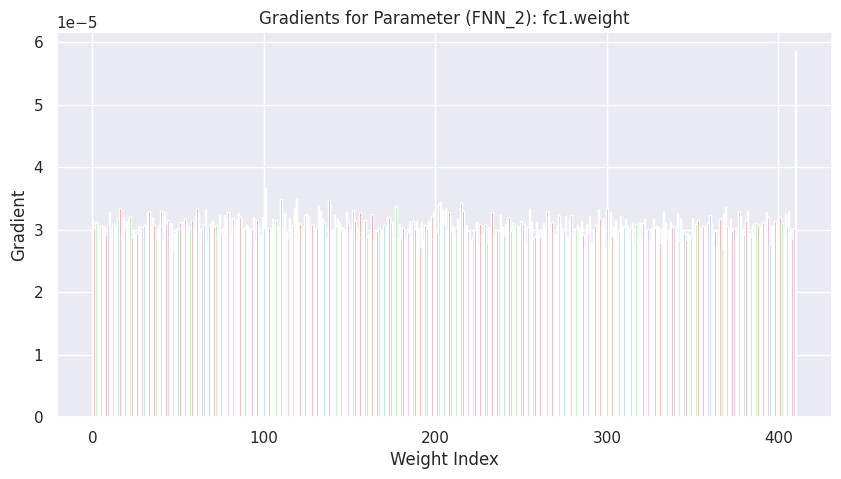

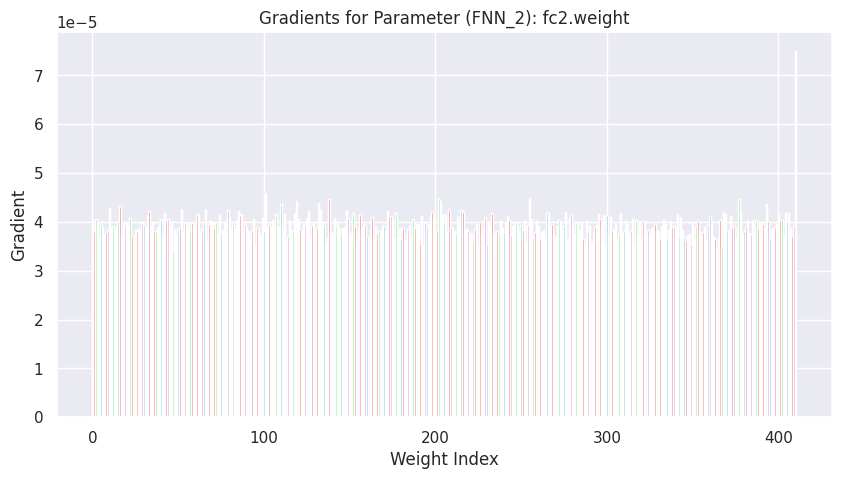

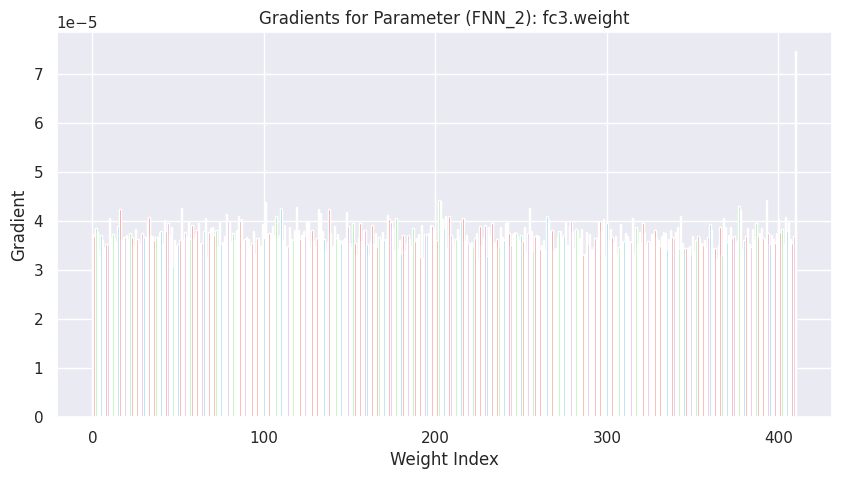

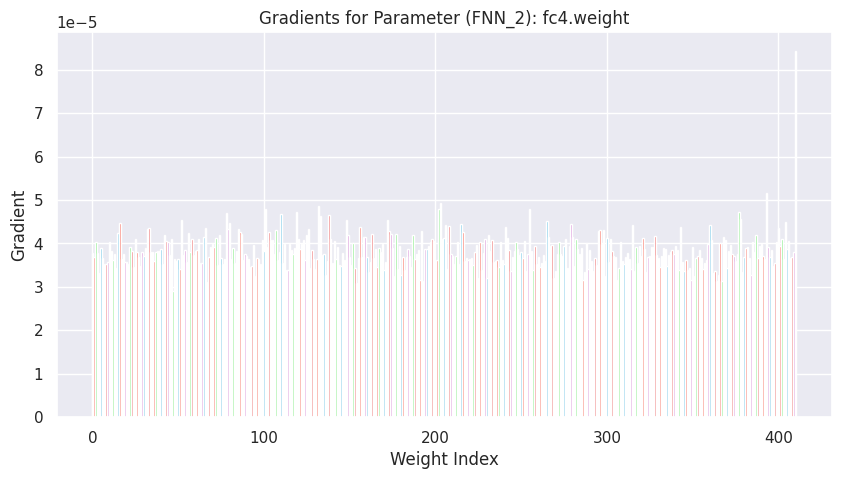

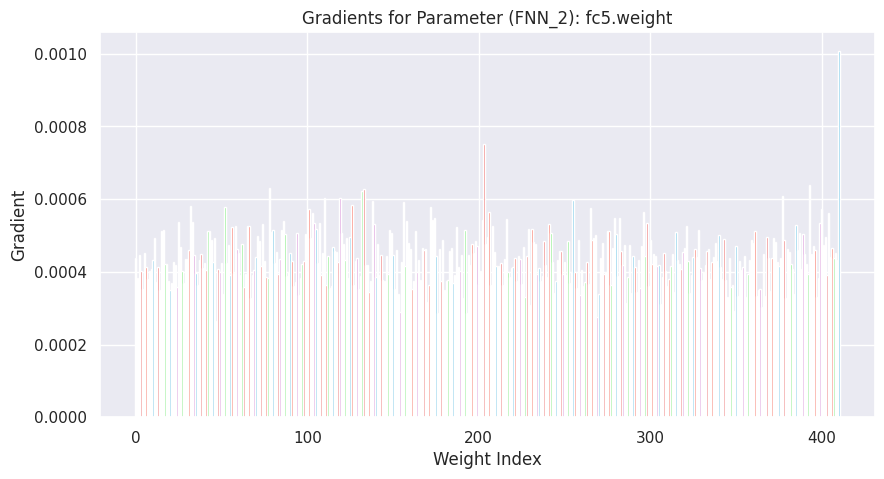

In [45]:
# Define custom colors for the bar plot
bar_colors_fnn0 = ['steelblue', 'darkorange', 'limegreen', 'red', 'purple']
bar_colors_fnn2 = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'plum']

# Iterate over the weight parameters and their gradients for FNN_0
for param_name, gradients in fresh_gradients.items():
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(gradients)), gradients, color=bar_colors_fnn0)
    plt.xlabel('Weight Index')
    plt.ylabel('Gradient')
    plt.title(f'Gradients for Parameter (FNN_0): {param_name}')
    plt.show()

# Iterate over the weight parameters and their gradients for FNN_2
for param_name, gradients in _gradients.items():
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(gradients)), gradients, color=bar_colors_fnn2)
    plt.xlabel('Weight Index')
    plt.ylabel('Gradient')
    plt.title(f'Gradients for Parameter (FNN_2): {param_name}')
    plt.show()